# TP3 Deep Learning CNN : 
> Ce TP est effectué par :
**Sandra Mourali**- **Anas Chaibi** - **Salma Ghabri** - **Aziz Bellaaj** - **Louay Badri**
---

In [1]:
import numpy as np
import keras.backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

K.set_image_data_format("channels_first")
seed = 7
np.random.seed(seed)

2024-06-16 16:40:55.251219: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 16:40:56.343784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plotHistory(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy Curve")

    plt.subplot(1, 3, 2)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.plot(history.history["mean_io_u"])
    plt.plot(history.history["val_mean_io_u"])
    plt.ylabel("IoU")
    plt.xlabel("Epochs")
    plt.legend(["Training", "Validation"])
    plt.title("IoU Curve")

    plt.subplot(1, 3, 3)
    plt.grid()
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(["Training", "Validation"], loc="upper right")
    plt.title("Loss Curve")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.plot(history.history["precision"])
    plt.plot(history.history["val_precision"])
    plt.ylabel("Precision")
    plt.xlabel("Epochs")
    plt.legend(["Training", "Validation"])
    plt.title("Precision Curve")

    plt.subplot(1, 3, 2)
    plt.ylim(0, 1.1)
    plt.grid()
    plt.plot(history.history["recall"])
    plt.plot(history.history["val_recall"])
    plt.ylabel("Recall")
    plt.xlabel("Epochs")
    plt.legend(["Training", "Validation"])
    plt.title("Recall Curve")

    plt.tight_layout()
    plt.savefig("combined_curves.pdf")
    plt.show()
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues
):
    title = "Normalized confusion matrix"

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax

In [3]:
def predictModel(modelPath):
    loaded_model = load_keras_model(modelPath)
    (X_unseen, y_unseen), _, _ = get_data_mnist()
    X_unseen = X_unseen.reshape(X_unseen.shape[0], 28, 28, 1).astype("float32") / 255
    predictions = loaded_model.predict(X_unseen)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_unseen, axis=1)
    classes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # for MNIST
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=classes, title="Confusion matrix")
    plt.show()

In [4]:
def get_data_mnist():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype("float32")
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    num_classes = y_test.shape[1]
    return (X_train, y_train), (X_test, y_test), num_classes

In [5]:
IoU = tf.keras.metrics.MeanIoU(num_classes=16)


def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=200,
        verbose=1,
    )
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Model score : %.2f%%" % (scores[1] * 100))
    print("Model error rate : %.2f%%" % (100 - scores[1] * 100))
    return history


def print_model_error_rate(model, X_test, y_test):
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Model score : %.2f%%" % (scores[1] * 100))
    print("Model error rate : %.2f%%" % (100 - scores[1] * 100))

2024-06-16 16:40:58.916473: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 16:40:59.157695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 16:40:59.157765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 16:40:59.159250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 16:40:59.159310: I external/local_xla/xla/stream_executor

In [6]:
def save_keras_model(model, filename):
    model_json = model.to_json()
    with open(filename + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(filename + ".h5")


def load_keras_model(filename):
    json_file = open(filename + ".json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(filename + ".h5")
    return loaded_model

In [7]:
(X_train, y_train), (X_test, y_test), num_classes = get_data_mnist()
num_classes

10

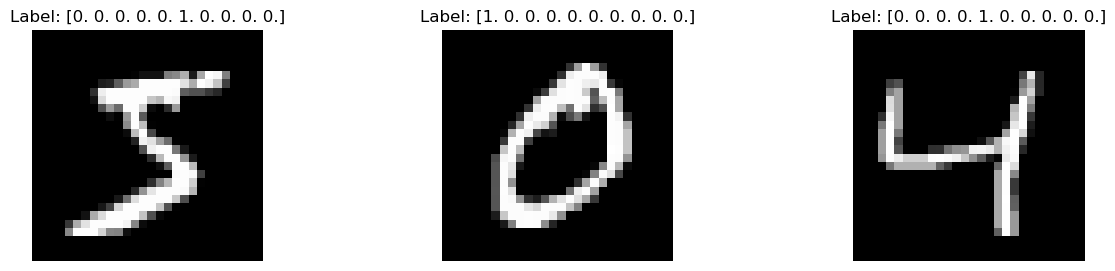

In [8]:
def plot_mnist_samples(X_train, y_train, num_samples=3):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
        plt.title(f"Label: {y_train[i]}")
        plt.axis("off")
    plt.show()


(X_train, y_train), _, _ = get_data_mnist()
plot_mnist_samples(X_train, y_train)

# Model Definition :

In [9]:
def small_model(num_classes):
    model = Sequential()
    model.add(
        Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation="relu", padding="same")
    )
    model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
    model.add(Flatten())
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy", IoU, "precision", "recall"],
    )
    return model


num_classes = 10
(X_train, y_train), (X_test, y_test), num_classes = get_data_mnist()
small_cnn = small_model(10)
history_small = train_and_evaluate(small_cnn, X_train, y_train, X_test, y_test)

/home/azizb/anaconda3/envs/data-science/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


2024-06-16 16:41:02.646403: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-06-16 16:41:02.846570: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
I0000 00:00:1718552464.119510   47528 service.cc:145] XLA service 0x7fe264006670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718552464.119868   47528 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-16 16:41:04.190971: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-16 16:41:04.370383: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 45/300 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3715 - loss: 9.9480 - mean_io_u: 0.4542 - precision: 0.3787 - recall: 0.3631 

I0000 00:00:1718552468.377120   47528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6894 - loss: 3.0925 - mean_io_u: 0.4542 - precision: 0.7046 - recall: 0.6778 - val_accuracy: 0.9242 - val_loss: 0.2677 - val_mean_io_u: 0.4547 - val_precision: 0.9314 - val_recall: 0.9181
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9374 - loss: 0.2147 - mean_io_u: 0.4580 - precision: 0.9449 - recall: 0.9320 - val_accuracy: 0.9505 - val_loss: 0.1739 - val_mean_io_u: 0.4608 - val_precision: 0.9562 - val_recall: 0.9474
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9589 - loss: 0.1419 - mean_io_u: 0.4635 - precision: 0.9636 - recall: 0.9543 - val_accuracy: 0.9625 - val_loss: 0.1323 - val_mean_io_u: 0.4649 - val_precision: 0.9668 - val_recall: 0.9601
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9704 - loss: 0.0946 - mean_io_u: 0.4730 - precision: 0.9741 - recall: 0.9673 - val_accuracy: 0.9670 - val_loss: 0.1194 - val_mean_io_u: 0.4737 - val_precision: 0.9707 - val_recall: 0.

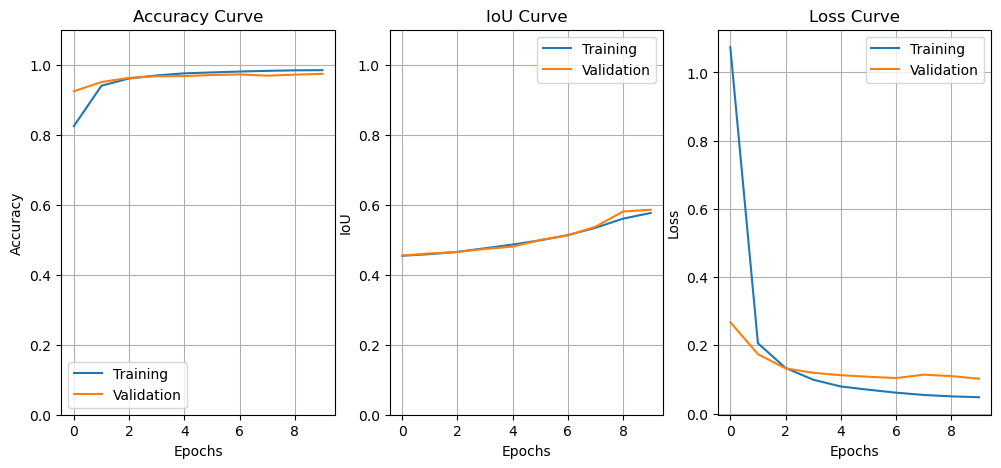

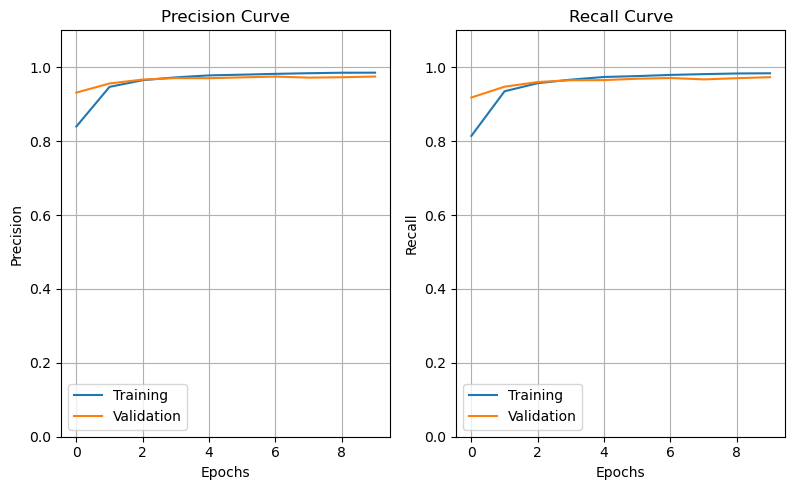

<Figure size 640x480 with 0 Axes>

In [10]:
plotHistory(history_small)

In [11]:
print_model_error_rate(small_cnn, X_test, y_test)

Model score : 97.40%
Model error rate : 2.60%


In [12]:
save_keras_model(small_cnn, "small_cnn.weights")

In [13]:
load_keras_model("small_cnn.weights")

<Sequential name=sequential, built=True>

## Medium CNN :

In [14]:
def medium_cnn():
    model = Sequential()
    model.add(
        Conv2D(32, (3, 3), padding="same", input_shape=(28, 28, 1), activation="relu")
    )
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy", IoU, "precision", "recall"],
    )
    return model


X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32") / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype("float32") / 255
medium_cnn = medium_cnn()
medium_history = train_and_evaluate(medium_cnn, X_train, y_train, X_test, y_test)

/home/azizb/anaconda3/envs/data-science/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-16 16:41:26.924483: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10


2024-06-16 16:41:27.149681: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7420 - loss: 0.9014 - mean_io_u: 0.4937 - precision: 0.8900 - recall: 0.5620 - val_accuracy: 0.9398 - val_loss: 0.2082 - val_mean_io_u: 0.4500 - val_precision: 0.9560 - val_recall: 0.9272
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9311 - loss: 0.2288 - mean_io_u: 0.4500 - precision: 0.9484 - recall: 0.9158 - val_accuracy: 0.9591 - val_loss: 0.1409 - val_mean_io_u: 0.4500 - val_precision: 0.9672 - val_recall: 0.9510
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9488 - loss: 0.1715 - mean_io_u: 0.4501 - precision: 0.9605 - recall: 0.9386 - val_accuracy: 0.9663 - val_loss: 0.1150 - val_mean_io_u: 0.4501 - val_precision: 0.9728 - val_recall: 0.9600
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9584 - loss: 0.1396 - mean_io_u: 0.4502 - precision: 0.9663 - recall: 0.9503 - val_accuracy: 0.9715 - val_loss: 0.0947 - val_mean_io_u: 0.4501 - val_precision: 0.9762 - val_recall: 0.

Model score : 98.15%
Model error rate : 1.85%


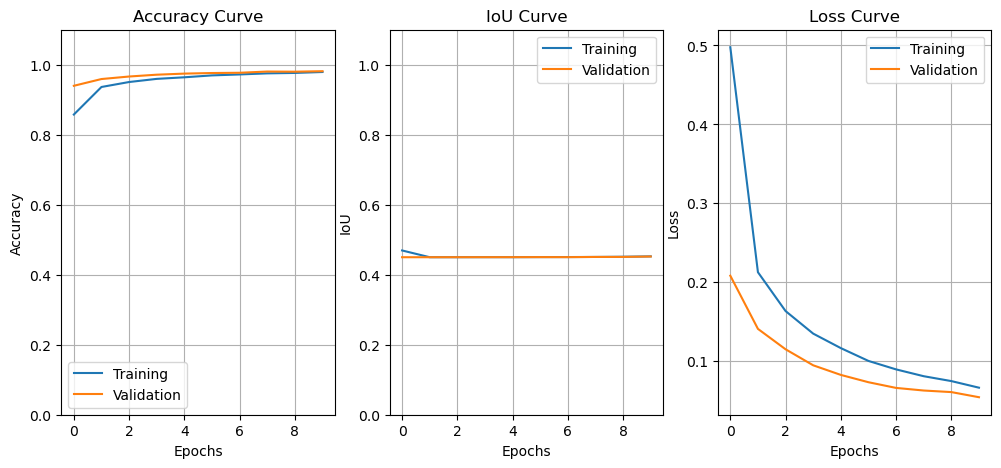

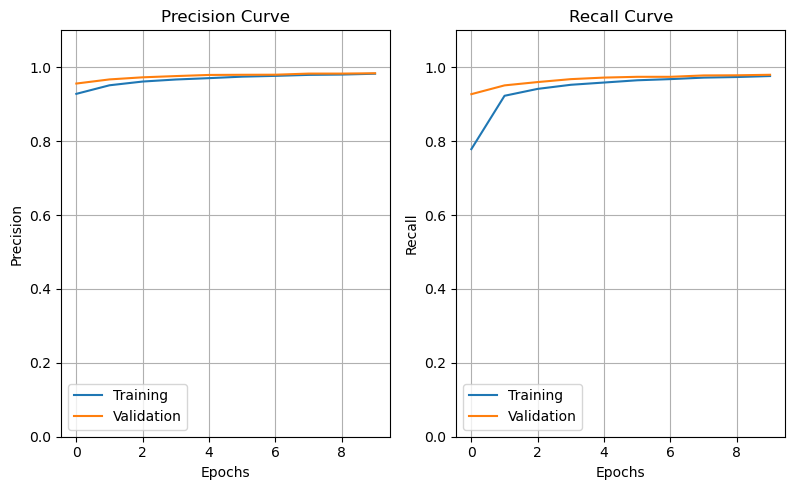

<Figure size 640x480 with 0 Axes>

In [15]:
print_model_error_rate(medium_cnn, X_test, y_test)
plotHistory(medium_history)
save_keras_model(medium_cnn, "medium_cnn.weights")

In [16]:
def large_cnn():
    model = Sequential()
    model.add(
        Conv2D(30, (5, 5), padding="same", input_shape=(28, 28, 1), activation="relu")
    )
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy", IoU, "precision", "recall"],
    )
    return model


X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32") / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype("float32") / 255
large_cnn = large_cnn()
large_history = train_and_evaluate(medium_cnn, X_train, y_train, X_test, y_test)

/home/azizb/anaconda3/envs/data-science/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-16 16:41:47.327931: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2680 - loss: 2.2291 - mean_io_u: 0.4500 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6433 - val_loss: 1.8707 - val_mean_io_u: 0.4500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6310 - loss: 1.6099 - mean_io_u: 0.4500 - precision: 0.9400 - recall: 0.0629 - val_accuracy: 0.7997 - val_loss: 0.8733 - val_mean_io_u: 0.4500 - val_precision: 0.9520 - val_recall: 0.4506
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7679 - loss: 0.8540 - mean_io_u: 0.4500 - precision: 0.9228 - recall: 0.4921 - val_accuracy: 0.8494 - val_loss: 0.5834 - val_mean_io_u: 0.4500 - val_precision: 0.9362 - val_recall: 0.7188
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8187 - loss: 0.6270 - mean_io_u: 0.4500 - precision: 0.9095 - recall: 0.7031 - val_accuracy: 0.8767 - val_loss: 0.4624 - val_mean_io_u: 0.4500 - val_precisi

Model score : 10.46%
Model error rate : 89.54%


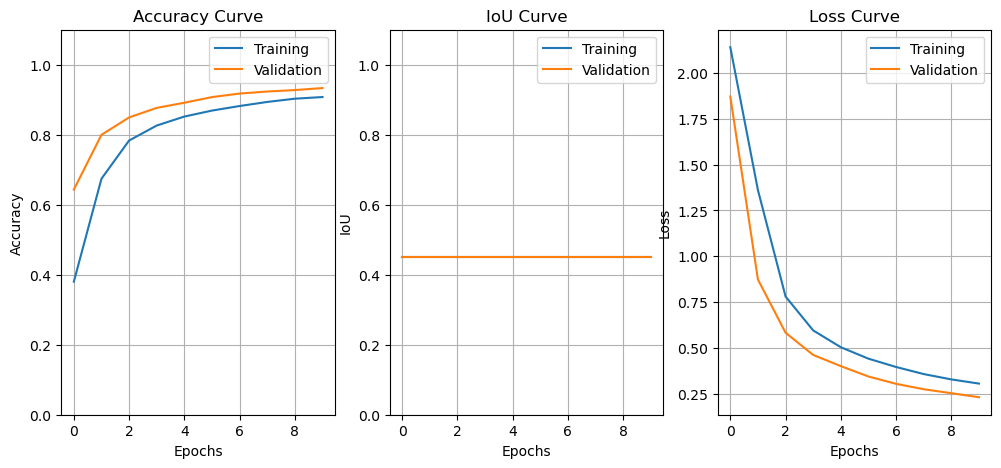

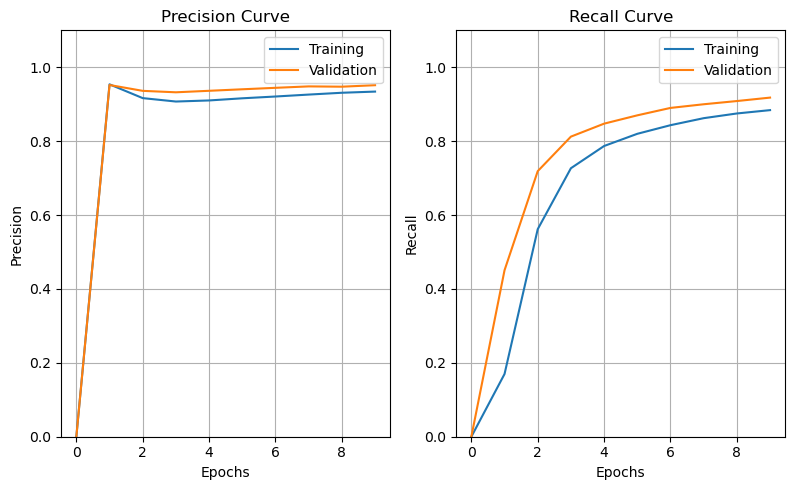

<Figure size 640x480 with 0 Axes>

In [17]:
print_model_error_rate(large_cnn, X_test, y_test)
plotHistory(large_history)
save_keras_model(large_cnn, "large_cnn.weights")

## Load model weights and perform classifications with it :

In [18]:
def load_keras_model(filename):
    json_file = open(filename + ".json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(filename + ".h5")
    return loaded_model


loaded_model = load_keras_model("small_cnn.weights")

(X_unseen, y_unseen), _, _ = get_data_mnist()
X_unseen = X_unseen.reshape(X_unseen.shape[0], 28, 28, 1).astype("float32") / 255

predictions = loaded_model.predict(X_unseen)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [19]:
predictions

array([[0.08692339, 0.10236219, 0.0976912 , ..., 0.1000754 , 0.09717785,
        0.09562288],
       [0.09967202, 0.10145131, 0.09795909, ..., 0.10066193, 0.09775239,
        0.09742261],
       [0.08776311, 0.10722993, 0.09799141, ..., 0.10176741, 0.1004246 ,
        0.10099399],
       ...,
       [0.0880756 , 0.10106698, 0.09419133, ..., 0.09742124, 0.10131225,
        0.09701434],
       [0.0930312 , 0.103657  , 0.09689233, ..., 0.09934963, 0.09829157,
        0.09274385],
       [0.09310398, 0.0967737 , 0.09614857, ..., 0.10090461, 0.10465888,
        0.09549544]], dtype=float32)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


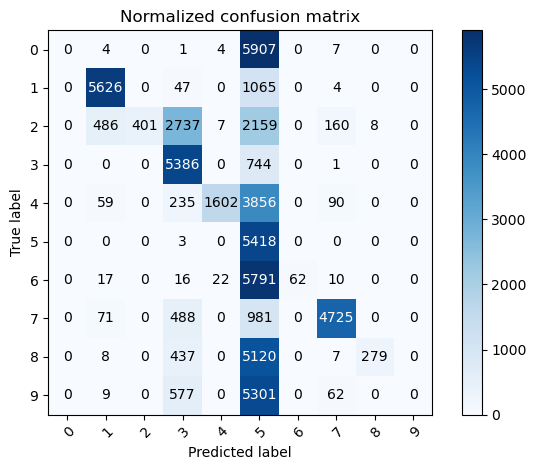

In [20]:
predictModel("small_cnn.weights")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


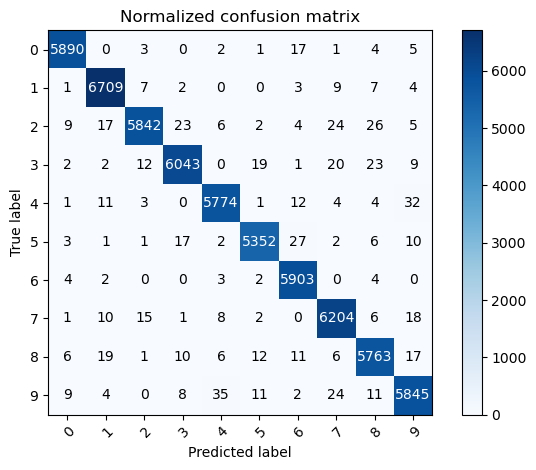

In [21]:
predictModel("medium_cnn.weights")

/home/azizb/anaconda3/envs/data-science/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


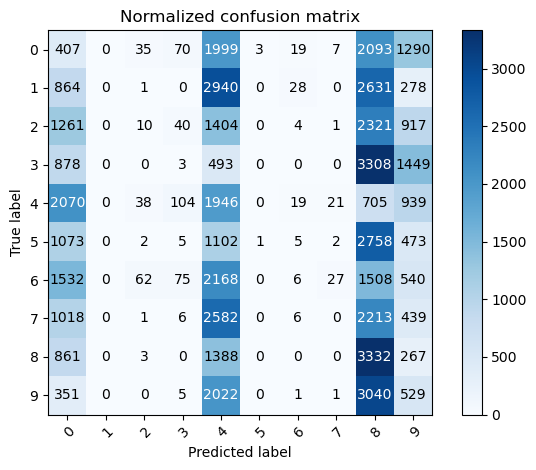

In [22]:
predictModel("large_cnn.weights")